In [71]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from scipy.stats import randint, uniform, sem, t

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,
    roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils import resample

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# Create directories for saving results and cached models
os.makedirs('results', exist_ok=True)
os.makedirs('results/baseline', exist_ok=True)
os.makedirs('results/hybrid', exist_ok=True)
os.makedirs('cache', exist_ok=True)  # New directory for cached models

In [51]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
dataset_type = 'hybrid'

# Step 1: Exploratory Data Analysis (EDA)

In [4]:
# Load the dataset
train_path = f'../data/train_{dataset_type}.csv'
test_path = f'../data/test_{dataset_type}.csv'
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Successfully loaded {dataset_type} datasets:")
    print(f"Training shape: {train_df.shape}")
    print(f"Testing shape: {test_df.shape}")
except FileNotFoundError:
    print(f"Error: Could not find {dataset_type} dataset files. Please check file paths.")
else:
    # Basic dataset information
    print("\nTraining Dataset Overview:")
    print(f"Columns: {train_df.columns.tolist()}")
    print("\nData Types:")
    print(train_df.dtypes)
    
    # Target distribution
    target_col = 'Event Classification'
    target_dist = train_df[target_col].value_counts(normalize=True).reset_index()
    target_dist.columns = ['Class', 'Proportion']
    print("\nTarget Distribution:")
    print(target_dist)
    
    # Visualize target distribution
    os.makedirs(f'results/{dataset_type}', exist_ok=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Proportion', data=target_dist)
    plt.title(f'Target Distribution - {dataset_type.capitalize()} Dataset')
    plt.ylabel('Proportion')
    plt.savefig(f'results/{dataset_type}/target_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

Successfully loaded hybrid datasets:
Training shape: (76065, 330)
Testing shape: (19017, 330)

Training Dataset Overview:
Columns: ['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'Is_US', 'ProductClassification_Class II', 'ProductClassification_Class III', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'Status_Terminated', 'Business_Structure_Association', 'Business_Structure_Company', 'Business_Structure_Corporation', 'Business_Structure_Inc', 'Business_Structure_LLC', 'Business_Structure_LLP', 'Business_Structure_LP', 'Business_Structure_Ltd', 'Business_Structure_Non-Profit', 'Business_Structure_Other', 'Business_Structure_PLC', 'Business_Structure_SA', 'text_svd_0', 'text_svd_1', 'text_svd_2', 'text_svd_3', 'text_svd_4', 'text_svd_5', 'text_svd_6', 'text_svd_7', 'text_svd_8', 'text_svd_9', 'text_svd_10', 'text_svd_11', 'text_svd_12', '

# Step 2: Data Cleaning (Validation)

In [5]:
# Check for missing values
missing_values = train_df.isnull().sum()
print("\nMissing values in training data:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")


Missing values in training data:
No missing values found


# Step 3: Data Preparation

In [6]:
# Define features (X) and target (y)
X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

In [7]:
# Ensure test data has the same columns as train data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

In [8]:
# Encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
class_names = le.classes_
print(f"Target Classes: {class_names}")

Target Classes: ['Class I' 'Class II' 'Class III']


# Step 4: Train-Test Split Validation

In [9]:
# The split was done in preprocessing, but validate proportions
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Test set proportion: {:.2f}%".format(100 * X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])))
print("\nTraining class distribution:")
print(pd.Series(y_train_encoded).value_counts(normalize=True))
print("\nTest class distribution:")
print(pd.Series(y_test_encoded).value_counts(normalize=True))

Training set size: 76065
Test set size: 19017
Test set proportion: 20.00%

Training class distribution:
1    0.708065
0    0.211516
2    0.080418
Name: proportion, dtype: float64

Test class distribution:
1    0.708103
0    0.211495
2    0.080402
Name: proportion, dtype: float64


# Step 5: Feature Engineering Validation

In [10]:
# Display number of features
print(f"Number of features: {X_train.shape[1]}")

Number of features: 329


In [11]:
# Display feature categories
temporal_features = [col for col in X_train.columns if any(x in col for x in ['Month', 'Day', 'Year', 'Week'])]
text_features = [col for col in X_train.columns if 'text_svd_' in col]
categorical_features = [col for col in X_train.columns if any(x in col for x in ['Classification', 'Type', 'Status', 'Structure'])]
print(f"Temporal features: {len(temporal_features)}")
print(f"Text-derived features: {len(text_features)}")
print(f"Categorical features: {len(categorical_features)}")

Temporal features: 7
Text-derived features: 300
Categorical features: 21


# Step 6: Pre-processed Dataset Validation

In [12]:
# Check for any remaining issues
print("Checking for infinity or NaN values...")
inf_count = np.isinf(X_train.values).sum()
nan_count = np.isnan(X_train.values).sum()
if inf_count > 0 or nan_count > 0:
    print(f"Warning: Found {inf_count} infinity values and {nan_count} NaN values")
    # Handle inf/nan values if necessary
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    print("No infinity or NaN values found.")

Checking for infinity or NaN values...
No infinity or NaN values found.


# Step 7: Logistic Regression

In [13]:
logreg_cache_path = 'cache/logreg_grid_search.joblib'

if os.path.exists(logreg_cache_path):
    print("Loading cached Logistic Regression grid search results...")
    grid_search = joblib.load(logreg_cache_path)
else:
    print("Running Logistic Regression grid search...")
    logreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
    ])
    
    # Hyperparameters for both L1 and L2
    param_grid = {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [0.01, 0.1, 1, 10, 100]
    }
    
    grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)
    # Cache the results
    joblib.dump(grid_search, logreg_cache_path)

print("Best Parameters:", grid_search.best_params_)

Running Logistic Regression grid search...
Best Parameters: {'logreg__C': 10, 'logreg__penalty': 'l2'}


In [14]:
# Best model
best_model = grid_search.best_estimator_

In [15]:
# Predict on test data
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

In [16]:
# Metrics
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

     Class I       0.99      0.96      0.98      4022
    Class II       0.99      0.99      0.99     13466
   Class III       0.95      0.97      0.96      1529

    accuracy                           0.99     19017
   macro avg       0.98      0.98      0.98     19017
weighted avg       0.99      0.99      0.99     19017



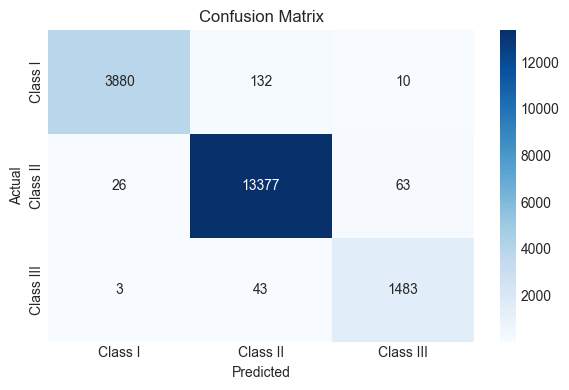

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/logreg_confusion_matrix.png', dpi=300)
plt.show()
plt.close()

For multi-class problems, we need to use a one-vs-rest approach for ROC curves

In [22]:
# Calculate ROC AUC for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

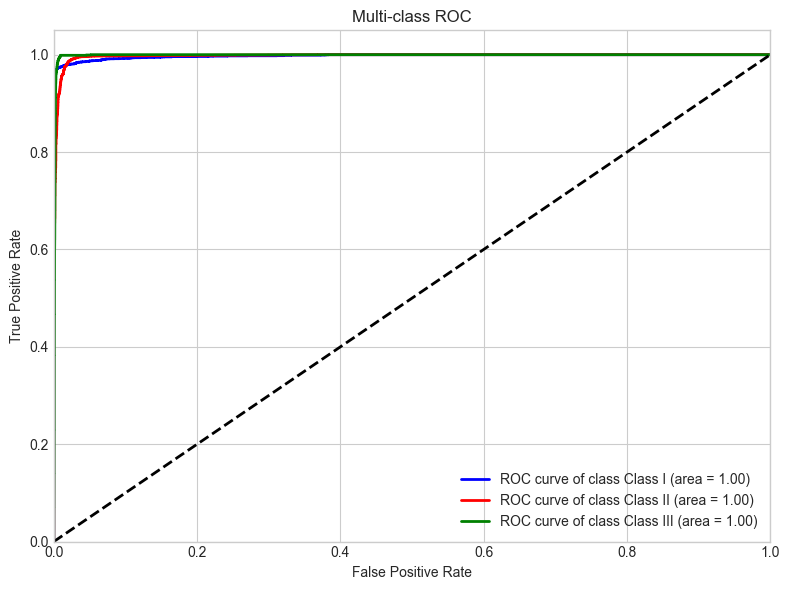

In [23]:
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color, cls in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {cls} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/logreg_roc_curves.png', dpi=300)
plt.show()
plt.close()

In [24]:
# Extract feature names and coefficients
feature_names = X_train.columns
coefficients = best_model.named_steps['logreg'].coef_[0]

In [25]:
# Create DataFrame for visualization
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

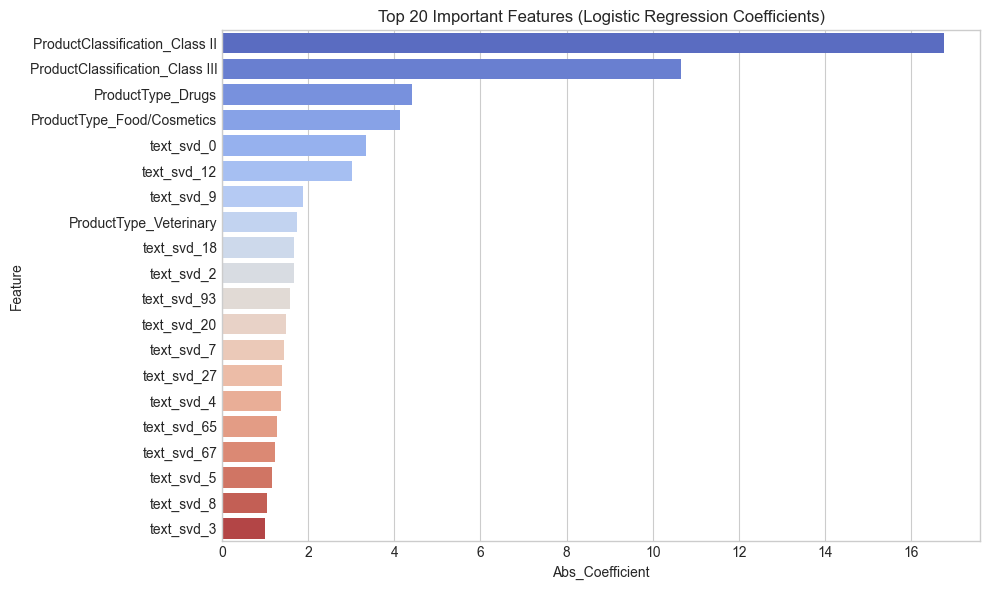

In [26]:
# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(20), x='Abs_Coefficient', y='Feature', palette='coolwarm')
plt.title("Top 20 Important Features (Logistic Regression Coefficients)")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/logreg_feature_importance.png', dpi=300)
plt.show()
plt.close()

In [27]:
# Feature variance
variance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Variance': X_train.var()
}).sort_values(by='Variance', ascending=False)

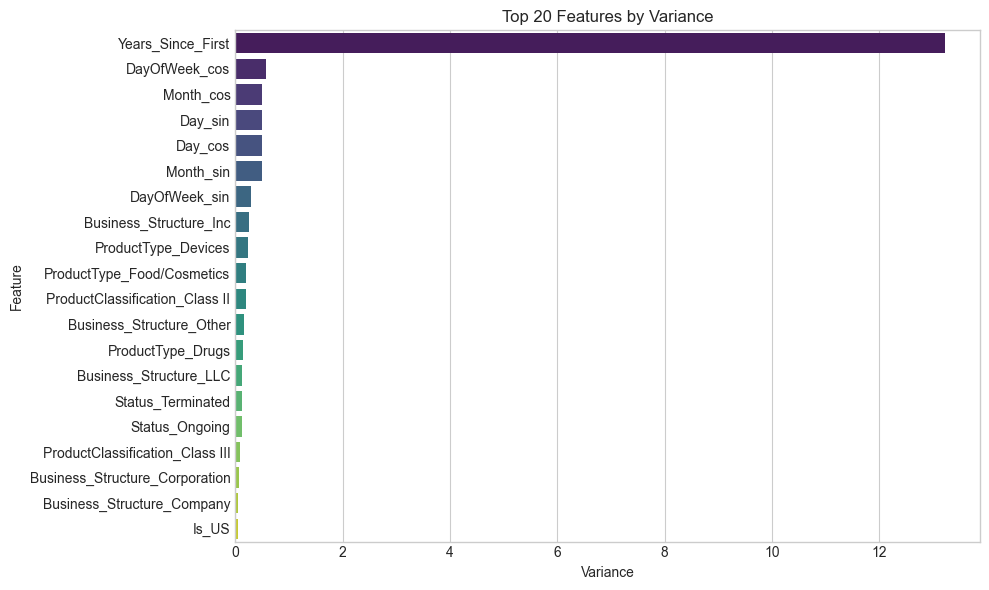

In [28]:
# Plot top 20 by variance
plt.figure(figsize=(10, 6))
sns.barplot(data=variance_df.head(20), x='Variance', y='Feature', palette='viridis')
plt.title("Top 20 Features by Variance")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/feature_variance_top20.png', dpi=300)
plt.show()
plt.close()

# Step 8: Bootstrap confidence intervals

In [31]:
bootstrap_cache_path = 'cache/bootstrap_metrics.joblib'

if os.path.exists(bootstrap_cache_path):
    print("Loading cached bootstrap results...")
    boot_metrics = joblib.load(bootstrap_cache_path)
else:
    print("Running bootstrap analysis (this may take a while)...")
    # Store bootstrap metrics
    boot_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
    # Number of bootstrap samples
    n_iterations = 1000
    random_state = 42
    
    for i in range(n_iterations):
        # Resample predictions
        indices = resample(np.arange(len(y_test_encoded)), replace=True, random_state=random_state + i)
        y_true_sample = y_test_encoded[indices]
        y_pred_sample = y_pred[indices]
        
        # Append scores with 'weighted' average for multi-class classification
        boot_metrics['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
        boot_metrics['precision'].append(precision_score(y_true_sample, y_pred_sample, average='weighted'))
        boot_metrics['recall'].append(recall_score(y_true_sample, y_pred_sample, average='weighted'))
        boot_metrics['f1'].append(f1_score(y_true_sample, y_pred_sample, average='weighted'))
    
    # Cache the results
    joblib.dump(boot_metrics, bootstrap_cache_path)

Loading cached bootstrap results...


In [32]:
# Create a summary table
ci_table = pd.DataFrame(columns=['Metric', 'Mean', '95% CI Lower', '95% CI Upper'])
rows_list = []
for metric in boot_metrics:
    scores = boot_metrics[metric]
    mean = np.mean(scores)
    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    
    rows_list.append({
        'Metric': metric.capitalize(),
        'Mean': round(mean, 4),
        '95% CI Lower': round(lower, 4),
        '95% CI Upper': round(upper, 4)
    })

In [33]:
# Create the DataFrame from the list of rows
ci_table = pd.DataFrame(rows_list)

In [34]:
# Display the table
print("\nConfidence Intervals (95%) for Test Set Metrics:")
print(ci_table)


Confidence Intervals (95%) for Test Set Metrics:
      Metric    Mean  95% CI Lower  95% CI Upper
0   Accuracy  0.9854        0.9836        0.9870
1  Precision  0.9855        0.9838        0.9871
2     Recall  0.9854        0.9836        0.9870
3         F1  0.9854        0.9836        0.9870


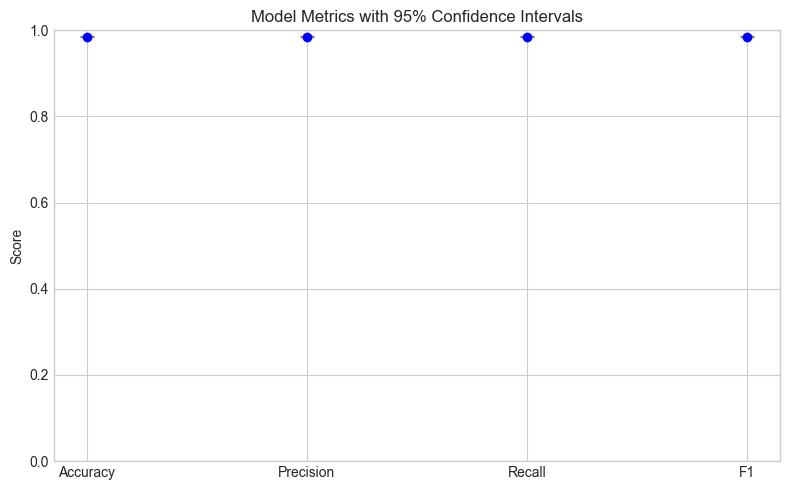

In [35]:
# Plot the confidence intervals
plt.figure(figsize=(8, 5))
plt.errorbar(ci_table['Metric'], ci_table['Mean'],
             yerr=[ci_table['Mean'] - ci_table['95% CI Lower'], ci_table['95% CI Upper'] - ci_table['Mean']],
             fmt='o', capsize=5, color='blue', ecolor='gray', elinewidth=3)
plt.title("Model Metrics with 95% Confidence Intervals")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/confidence_intervals.png', dpi=300)
plt.show()
plt.close()

# Step 9: Decision Tree

In [36]:
dt_cache_path = 'cache/dt_grid_search.joblib'

if os.path.exists(dt_cache_path):
    print("Loading cached Decision Tree grid search results...")
    grid_dt = joblib.load(dt_cache_path)
else:
    print("Running Decision Tree grid search (this may take a while)...")
    # Define parameter grid
    param_grid_dt = {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Initialize the model
    dt = DecisionTreeClassifier(random_state=42)
    
    # Grid search
    grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_dt.fit(X_train, y_train_encoded)
    
    # Cache the results
    joblib.dump(grid_dt, dt_cache_path)

Running Decision Tree grid search (this may take a while)...


In [37]:
# Best model
best_dt = grid_dt.best_estimator_
print("\nBest Decision Tree Parameters:")
print(grid_dt.best_params_)


Best Decision Tree Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [38]:
# Predict
y_pred_dt = best_dt.predict(X_test)

In [39]:
# Classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt, target_names=class_names))


Decision Tree Classification Report:
              precision    recall  f1-score   support

     Class I       0.98      0.98      0.98      4022
    Class II       0.99      0.99      0.99     13466
   Class III       0.96      0.96      0.96      1529

    accuracy                           0.98     19017
   macro avg       0.98      0.98      0.98     19017
weighted avg       0.98      0.98      0.98     19017



<Figure size 800x600 with 0 Axes>

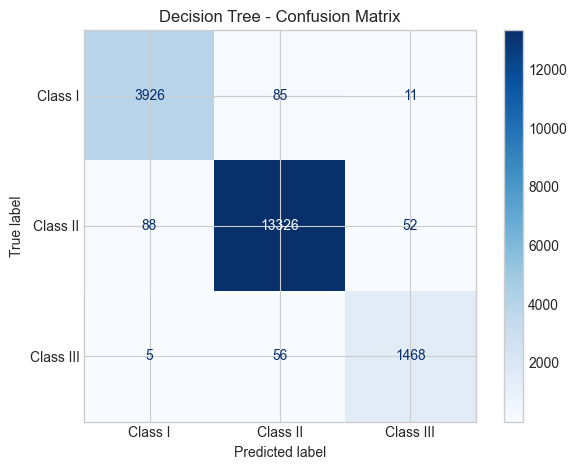

In [40]:
# Confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test_encoded, display_labels=class_names, cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/dt_confusion_matrix.png', dpi=300)
plt.show()

plt.close()

In [41]:
# Feature importance
importances_dt = best_dt.feature_importances_
feature_names = X_train.columns

In [42]:
# Create dataframe and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_dt})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

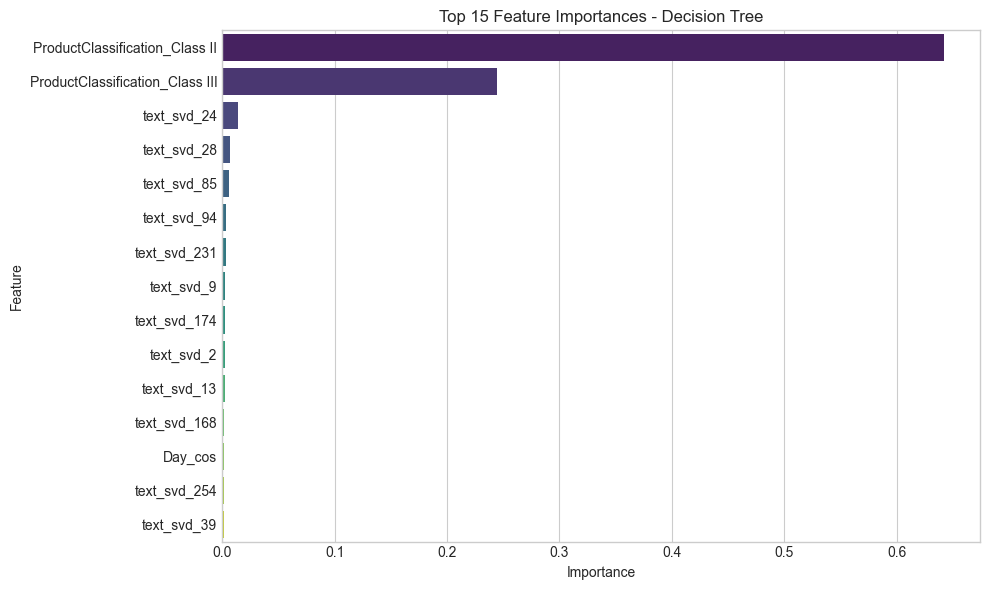

In [43]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 15 Feature Importances - Decision Tree")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/dt_feature_importance.png', dpi=300)
plt.show()
plt.close()

# Step 10: Decision Tree Bootstrap

In [44]:
dt_bootstrap_cache_path = 'cache/dt_bootstrap_metrics.joblib'

# Bootstrap function
def bootstrap_metrics(y_true, y_pred, n_bootstraps=1000, alpha=0.95):
    np.random.seed(42)
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    for i in range(n_bootstraps):
        indices = resample(range(len(y_true)))
        y_true_sample = np.array(y_true)[indices]
        y_pred_sample = np.array(y_pred)[indices]
        
        metrics['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
        metrics['precision'].append(precision_score(y_true_sample, y_pred_sample, average='weighted', zero_division=0))
        metrics['recall'].append(recall_score(y_true_sample, y_pred_sample, average='weighted'))
        metrics['f1'].append(f1_score(y_true_sample, y_pred_sample, average='weighted'))
    
    # Calculate CIs
    results = {}
    for metric_name, values in metrics.items():
        lower = np.percentile(values, (1 - alpha) / 2 * 100)
        upper = np.percentile(values, (1 + alpha) / 2 * 100)
        mean = np.mean(values)
        results[metric_name] = (mean, lower, upper)
    return results

if os.path.exists(dt_bootstrap_cache_path):
    print("Loading cached Decision Tree bootstrap results...")
    dt_ci = joblib.load(dt_bootstrap_cache_path)
else:
    print("Running Decision Tree bootstrap analysis...")
    # Get confidence intervals
    dt_ci = bootstrap_metrics(y_test_encoded, y_pred_dt)
    
    # Cache the results
    joblib.dump(dt_ci, dt_bootstrap_cache_path)

Running Decision Tree bootstrap analysis...


In [45]:
# Display nicely as table
ci_df = pd.DataFrame.from_dict(dt_ci, orient='index', columns=['Mean', 'Lower 95% CI', 'Upper 95% CI'])
ci_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-score']
print("\nDecision Tree Confidence Intervals (95%):")
print(ci_df.round(4))


Decision Tree Confidence Intervals (95%):
             Mean  Lower 95% CI  Upper 95% CI
Accuracy   0.9843        0.9824        0.9861
Precision  0.9843        0.9825        0.9861
Recall     0.9843        0.9824        0.9861
F1-score   0.9843        0.9824        0.9861


# Step 11: RFECV Feature Selection and Ensemble Models

In [46]:
# Helper to plot feature importances
def plot_feature_importance(importances, features, model_name, top_n=20):
    fi = pd.Series(importances, index=features).sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi.values, y=fi.index, palette="viridis")
    plt.title(f"{model_name} - Top {top_n} Feature Importances")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/{model_name.lower().replace(" ", "_")}_feature_importance.png', dpi=300)
    plt.close()

# Helper to compute and print mean accuracy with confidence interval
def report_accuracy(fold_scores):
    mean_acc = np.mean(fold_scores)
    ci = sem(fold_scores) * t.ppf((1 + 0.95) / 2., len(fold_scores)-1)
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {ci:.4f}")
    return mean_acc, ci

# Helper to perform RFECV feature selection with caching
def perform_rfecv(model, X, y, cv, model_name):
    rfecv_cache_path = f'cache/{model_name.lower().replace(" ", "_")}_rfecv.joblib'
    
    if os.path.exists(rfecv_cache_path):
        print(f"Loading cached RFECV results for {model_name}...")
        rfecv = joblib.load(rfecv_cache_path)
    else:
        print(f"Running RFECV feature selection for {model_name} (this may take a while)...")
        rfecv = RFECV(
            estimator=model,
            step=5,  # Remove 5 features at a time for faster computation
            min_features_to_select=10,  # Minimum number of features to keep
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        rfecv.fit(X, y)
        
        # Cache the results
        joblib.dump(rfecv, rfecv_cache_path)
    
    return rfecv

In [47]:
# Setup models for evaluation
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

In [48]:
# Store results
model_results = {}

In [49]:
# SMOTE for handling class imbalance
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_encoded)
print(f"Applied SMOTE: Original shape {X_train.shape}, Resampled shape {X_train_resampled.shape}")

Applied SMOTE: Original shape (76065, 329), Resampled shape (161577, 329)


In [50]:
# Evaluate each model using RFECV for feature selection
for name, model in models.items():
    ensemble_cache_path = f'cache/{name.lower().replace(" ", "_")}_cv_results.joblib'
    
    if os.path.exists(ensemble_cache_path):
        print(f"Loading cached {name} cross-validation results...")
        model_result = joblib.load(ensemble_cache_path)
        model_results[name] = model_result
    else:
        print(f"\n{'='*50}\nEvaluating Model: {name}\n{'='*50}")
        
        # Perform RFECV feature selection
        rfecv = perform_rfecv(model, X_train_resampled, y_train_resampled, 
                              StratifiedKFold(3, shuffle=True, random_state=42), name)
        
        # Get selected features
        selected_features = X_train.columns[rfecv.support_]
        print(f"RFECV selected {len(selected_features)} out of {X_train.shape[1]} features")
        
        # Plot RFECV results
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
                 rfecv.cv_results_['mean_test_score'], marker='o')
        plt.axvline(x=rfecv.n_features_, color='r', linestyle='--')
        plt.title(f'{name} - RFECV Results')
        plt.xlabel('Number of features')
        plt.ylabel('Cross-validation accuracy')
        plt.grid(True)
        plt.savefig(f'results/{dataset_type}/{name.lower().replace(" ", "_")}_rfecv.png', dpi=300)
        plt.close()
        
        # Cross-validation with selected features
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resampled, y_train_resampled), 1):
            print(f"  Fold {fold}/{n_folds}")
            X_tr, X_val = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[val_idx]
            y_tr, y_val = y_train_resampled[train_idx], y_train_resampled[val_idx]
            
            # Filter to selected features
            X_tr_sel = X_tr[selected_features]
            X_val_sel = X_val[selected_features]
            
            # Train model on selected features
            fitted_model = model.__class__(**model.get_params())
            fitted_model.fit(X_tr_sel, y_tr)
            preds = fitted_model.predict(X_val_sel)
            acc = accuracy_score(y_val, preds)
            fold_scores.append(acc)
        
        # Final report
        mean_acc, ci = report_accuracy(fold_scores)
        
        # Train final model on all resampled data with selected features
        final_model = model.__class__(**model.get_params())
        final_model.fit(X_train_resampled[selected_features], y_train_resampled)
        
        # Feature importance for the final model
        if hasattr(final_model, 'feature_importances_'):
            plot_feature_importance(final_model.feature_importances_, selected_features, name)
        
        # Save results
        model_result = {
            'fold_accuracies': fold_scores,
            'mean_accuracy': mean_acc,
            'confidence_interval': ci,
            'selected_features': selected_features,
            'final_model': final_model,
            'rfecv': rfecv
        }
        
        model_results[name] = model_result
        
        # Cache the results
        joblib.dump(model_result, ensemble_cache_path)
    
    # Print results from model_results
    print(f"\n{'='*50}\nModel: {name}\n{'='*50}")
    print(f"  Mean Accuracy: {model_results[name]['mean_accuracy']:.4f} ± {model_results[name]['confidence_interval']:.4f}")
    print(f"  Selected Features: {len(model_results[name]['selected_features'])}")
    
    # List top 10 selected features
    if 'final_model' in model_results[name] and hasattr(model_results[name]['final_model'], 'feature_importances_'):
        importances = model_results[name]['final_model'].feature_importances_
        selected_features = model_results[name]['selected_features']
        top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False).head(10)
        print("\n  Top 10 Features:")
        for feat, imp in top_features.items():
            print(f"    {feat}: {imp:.4f}")


Evaluating Model: Random Forest
Running RFECV feature selection for Random Forest (this may take a while)...
Fitting estimator with 329 features.
Fitting estimator with 324 features.
Fitting estimator with 319 features.
RFECV selected 314 out of 329 features
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean Accuracy: 0.9961 ± 0.0007

Model: Random Forest
  Mean Accuracy: 0.9961 ± 0.0007
  Selected Features: 314

  Top 10 Features:
    ProductClassification_Class III: 0.2073
    ProductClassification_Class II: 0.2010
    text_svd_2: 0.0344
    text_svd_0: 0.0247
    ProductType_Food/Cosmetics: 0.0218
    text_svd_1: 0.0196
    text_svd_5: 0.0189
    text_svd_3: 0.0171
    text_svd_6: 0.0160
    text_svd_4: 0.0126

Evaluating Model: XGBoost
Running RFECV feature selection for XGBoost (this may take a while)...
Fitting estimator with 329 features.
Fitting estimator with 324 features.
Fitting estimator with 319 features.
Fitting estimator with 314 features.
Fitting estimator w

# Step 12: Random Forest Hyperparameter Tuning

In [52]:
rf_grid_cache_path = 'cache/rf_grid_search.joblib'

if os.path.exists(rf_grid_cache_path):
    print("Loading cached Random Forest grid search results...")
    grid_search_rf = joblib.load(rf_grid_cache_path)
else:
    print("Running Random Forest grid search...")
    # Random Forest Hyperparameter Tuning
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    }
    
    grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                                param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_rf.fit(X_train, y_train_encoded)
    
    # Cache the results
    joblib.dump(grid_search_rf, rf_grid_cache_path)

print(f"Best Parameters for RF: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_

Running Random Forest grid search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for RF: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# Step 13: XGBoost Hyperparameter Tuning

In [53]:
xgb_grid_cache_path = 'cache/xgb_grid_search.joblib'

if os.path.exists(xgb_grid_cache_path):
    print("Loading cached XGBoost grid search results...")
    grid_search_xgb = joblib.load(xgb_grid_cache_path)
else:
    print("Running XGBoost grid search...")
    # XGBoost Hyperparameter Tuning
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    grid_search_xgb = GridSearchCV(XGBClassifier(eval_metric='mlogloss', random_state=42), 
                                 param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_xgb.fit(X_train, y_train_encoded)
    
    # Cache the results
    joblib.dump(grid_search_xgb, xgb_grid_cache_path)

print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
best_xgb_model = grid_search_xgb.best_estimator_

Running XGBoost grid search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


# Step 14: CatBoost Hyperparameter Tuning

In [54]:
catboost_grid_cache_path = 'cache/catboost_grid_search.joblib'

if os.path.exists(catboost_grid_cache_path):
    print("Loading cached CatBoost grid search results...")
    grid_search_cb = joblib.load(catboost_grid_cache_path)
else:
    print("Running CatBoost grid search...")
    # CatBoost Hyperparameter Tuning
    param_grid_cb = {
        'iterations': [500, 1000],
        'learning_rate': [0.01, 0.1],
        'depth': [6, 10],
        'l2_leaf_reg': [3, 5]
    }
    
    grid_search_cb = GridSearchCV(CatBoostClassifier(verbose=0, random_state=42), 
                                param_grid_cb, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_cb.fit(X_train, y_train_encoded)
    
    # Cache the results
    joblib.dump(grid_search_cb, catboost_grid_cache_path)

print(f"Best Parameters for CatBoost: {grid_search_cb.best_params_}")
best_cb_model = grid_search_cb.best_estimator_

Running CatBoost grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for CatBoost: {'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


# Step 15: Model Comparison

In [55]:
# Prepare comparison data
model_names = ['Random Forest', 'XGBoost', 'CatBoost']
mean_accuracies = [model_results['Random Forest']['mean_accuracy'], 
                   model_results['XGBoost']['mean_accuracy'], 
                   model_results['CatBoost']['mean_accuracy']]
confidence_intervals = [model_results['Random Forest']['confidence_interval'], 
                        model_results['XGBoost']['confidence_interval'], 
                        model_results['CatBoost']['confidence_interval']]

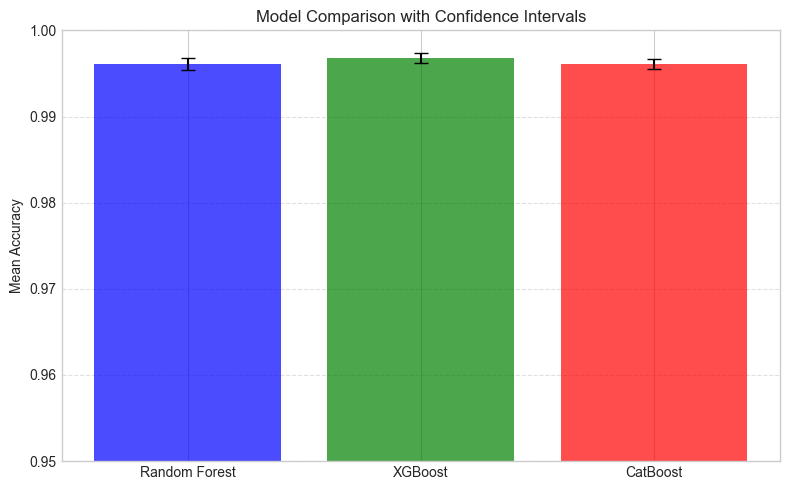

In [56]:
# Plot the comparison chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, mean_accuracies, yerr=confidence_intervals, capsize=5, 
        color=['blue', 'green', 'red'], alpha=0.7)
plt.ylabel('Mean Accuracy')
plt.title('Model Comparison with Confidence Intervals')
plt.ylim([0.95, 1.0])  # Adjusted to highlight differences
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/model_comparison.png', dpi=300)
plt.show()
plt.close()

# Step 16: Neural Network (MLPClassifier)

In [57]:
mlp_cache_path = 'cache/mlp_grid_search.joblib'

if os.path.exists(mlp_cache_path):
    print("Loading cached MLPClassifier grid search results...")
    grid_search_mlp = joblib.load(mlp_cache_path)
else:
    print("Running MLPClassifier grid search...")
    # Define parameter grid for hyperparameter tuning
    param_grid_mlp = {
        'hidden_layer_sizes': [(50,), (100,), (150,)],  # Example layer sizes
        'activation': ['relu', 'tanh'],  # Activation functions
        'solver': ['adam', 'sgd'],  # Optimization solvers
        'alpha': [0.0001, 0.001],  # Regularization
        'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    }
    
    # Initialize the model
    mlp = MLPClassifier(max_iter=1000, random_state=42)
    
    # Perform grid search for hyperparameter tuning
    grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, n_jobs=-1, verbose=1)
    grid_search_mlp.fit(X_train, y_train)
    
    # Cache the results
    joblib.dump(grid_search_mlp, mlp_cache_path)

# Best model from grid search
best_mlp_model = grid_search_mlp.best_estimator_

# Print best hyperparameters
print(f"Best Hyperparameters: {grid_search_mlp.best_params_}")

Running MLPClassifier grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


## Cross-validation accuracy

In [58]:
cv_accuracy = grid_search_mlp.best_score_

# Test accuracy
mlp_pred_cache_path = 'cache/mlp_predictions.joblib'

if os.path.exists(mlp_pred_cache_path):
    print("Loading cached MLPClassifier predictions...")
    mlp_pred_data = joblib.load(mlp_pred_cache_path)
    y_pred_mlp = mlp_pred_data['y_pred']
    test_accuracy = mlp_pred_data['test_accuracy']
else:
    y_pred_mlp = best_mlp_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_mlp)
    # Cache the predictions and accuracy
    mlp_pred_data = {'y_pred': y_pred_mlp, 'test_accuracy': test_accuracy}
    joblib.dump(mlp_pred_data, mlp_pred_cache_path)

In [59]:
# Classification report
class_report = classification_report(y_test, y_pred_mlp)
print(f"CV Accuracy: {cv_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(class_report)

CV Accuracy: 0.9938
Test Accuracy: 0.9929
Classification Report:
              precision    recall  f1-score   support

     Class I       1.00      0.99      0.99      4022
    Class II       1.00      0.99      1.00     13466
   Class III       0.95      0.99      0.97      1529

    accuracy                           0.99     19017
   macro avg       0.98      0.99      0.99     19017
weighted avg       0.99      0.99      0.99     19017



# Step 17: Final Model Evaluation and Comparison

In [60]:
# For ensemble models that used RFECV, evaluate on test data with selected features
test_accuracies = {}
for name, result in model_results.items():
    # Get selected features and final model
    selected_features = result['selected_features']
    final_model = result['final_model']
    
    # Predict on test set using selected features
    test_pred = final_model.predict(X_test[selected_features])
    test_acc = accuracy_score(y_test_encoded, test_pred)
    test_accuracies[name] = test_acc
    
    print(f"{name} Test Accuracy (with RFECV features): {test_acc:.4f}")

Random Forest Test Accuracy (with RFECV features): 0.9918
XGBoost Test Accuracy (with RFECV features): 0.9913
CatBoost Test Accuracy (with RFECV features): 0.9913


In [61]:
# Create a comprehensive comparison DataFrame
comparison_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest (RFECV)', 'XGBoost (RFECV)', 'CatBoost (RFECV)', 'MLPClassifier'],
    'Test Accuracy': [
        accuracy_score(y_test_encoded, y_pred),  # Logistic Regression
        accuracy_score(y_test_encoded, y_pred_dt),  # Decision Tree
        test_accuracies['Random Forest'],  # Random Forest with RFECV
        test_accuracies['XGBoost'],        # XGBoost with RFECV
        test_accuracies['CatBoost'],       # CatBoost with RFECV
        test_accuracy                      # MLP (already calculated)
    ],
    'Feature Count': [
        X_train.shape[1],                   # Logistic Regression (all features)
        X_train.shape[1],                   # Decision Tree (all features)
        len(model_results['Random Forest']['selected_features']),  # RF with RFECV
        len(model_results['XGBoost']['selected_features']),        # XGB with RFECV
        len(model_results['CatBoost']['selected_features']),       # CB with RFECV
        X_train.shape[1]                    # MLP (all features)
    ]
}

In [62]:
# Create the DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df['Test Accuracy'] = comparison_df['Test Accuracy'].apply(lambda x: f"{x:.4f}")
print("\nFinal Model Comparison:")
print(comparison_df)


Final Model Comparison:
                   Model Test Accuracy  Feature Count
0    Logistic Regression        0.9854            329
1          Decision Tree        0.9844            329
2  Random Forest (RFECV)        0.9918            314
3        XGBoost (RFECV)        0.9913            274
4       CatBoost (RFECV)        0.9913             39
5          MLPClassifier        0.9929            329


In [63]:
# Visualize the comparison
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [64]:
# Convert accuracy back to float for plotting
comparison_df['Test Accuracy'] = comparison_df['Test Accuracy'].astype(float)

[Text(0, 0, 'Logistic Regression'),
 Text(1, 0, 'Decision Tree'),
 Text(2, 0, 'Random Forest (RFECV)'),
 Text(3, 0, 'XGBoost (RFECV)'),
 Text(4, 0, 'CatBoost (RFECV)'),
 Text(5, 0, 'MLPClassifier')]

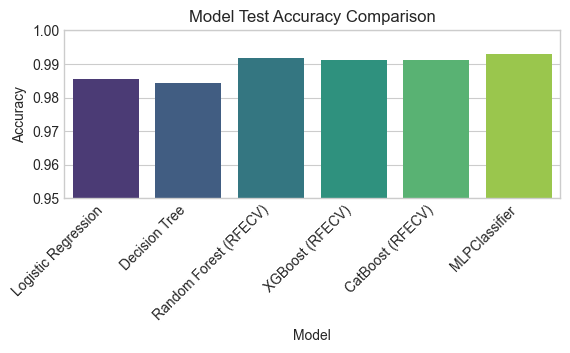

In [65]:
# Create bar plot for accuracy
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='Test Accuracy', data=comparison_df, palette='viridis', ax=ax1)
ax1.set_ylim(0.95, 1.0)  # Set y-axis limits to highlight differences
ax1.set_title('Model Test Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

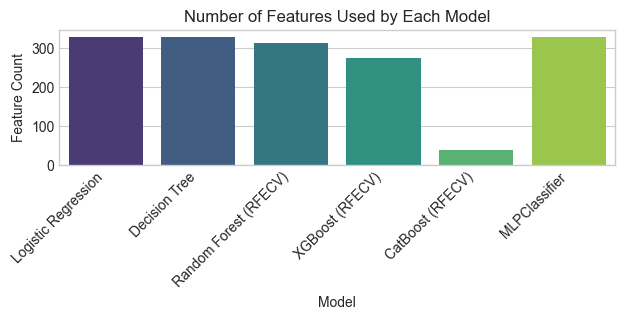

In [66]:
# Create bar plot for feature count
ax2 = plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='Feature Count', data=comparison_df, palette='viridis', ax=ax2)
ax2.set_title('Number of Features Used by Each Model')
ax2.set_ylabel('Feature Count')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/final_model_comparison.png', dpi=300)
plt.show()
plt.close()

In [67]:
# Save the comparison to CSV
comparison_df.to_csv(f'results/{dataset_type}/final_model_comparison.csv', index=False)

# Step 18: Save Final Models

In [68]:
# Save the best models for future use
models_to_save = {
    'logistic_regression': best_model,
    'decision_tree': best_dt,
    'random_forest_rfecv': model_results['Random Forest']['final_model'],
    'xgboost_rfecv': model_results['XGBoost']['final_model'],
    'catboost_rfecv': model_results['CatBoost']['final_model'],
    'mlp': best_mlp_model
}

In [69]:
# Save the selected features for RFECV models
rfecv_features = {
    'random_forest_features': list(model_results['Random Forest']['selected_features']),
    'xgboost_features': list(model_results['XGBoost']['selected_features']),
    'catboost_features': list(model_results['CatBoost']['selected_features'])
}

In [72]:
# Save the features list
features_path = 'cache/rfecv_selected_features.json'
with open(features_path, 'w') as f:
    json.dump(rfecv_features, f)

for name, model in models_to_save.items():
    model_path = f'cache/final_{name}_model.joblib'
    print(f"Saving {name} model to {model_path}")
    joblib.dump(model, model_path)

print("\nAll models saved successfully. Analysis complete.")

Saving logistic_regression model to cache/final_logistic_regression_model.joblib
Saving decision_tree model to cache/final_decision_tree_model.joblib
Saving random_forest_rfecv model to cache/final_random_forest_rfecv_model.joblib
Saving xgboost_rfecv model to cache/final_xgboost_rfecv_model.joblib
Saving catboost_rfecv model to cache/final_catboost_rfecv_model.joblib
Saving mlp model to cache/final_mlp_model.joblib

All models saved successfully. Analysis complete.
